<a href="https://colab.research.google.com/github/duberii/pid-playground/blob/main/activities/Drift_Chambers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drift Chambers and Tracks**
---
Welcome to Particle Identification Playground! In this activity, you will get a brief introduction to drift chambers and tacks.

**Before attempting this notebook, complete all of the activities in the Getting Started section.**

**After completing this notebook, you will be able to:**
*   Describe the role of drift chambers in a particle detector
*   Define a track and what kinds of particle leave tracks
*   Use individual hits to determine the position of a track
*   Find the momentum of a particle based on the curvature of a track

In [2]:
#@title Run this cell before starting
from IPython.display import YouTubeVideo
import plotly.express as px
import pandas as pd
import numpy as np
import ipywidgets as widgets
import plotly
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from google.colab import output
import xml.etree.ElementTree as ET
output.enable_custom_widget_manager()
!wget -q https://github.com/JeffersonLab/hdds/raw/master/CentralDC_HDDS.xml
!wget -q https://github.com/duberii/pid-playground/raw/main/data/CDChits.hdf5
track_fitting_events = pd.read_hdf("content/CDChits.hdf5","event1")
B = 1.7
ar = []
def to_center_of_orbit(r, theta, centerx,centery):
  tempx = r*np.cos(theta)
  tempy = r * np.sin(theta)
  new_r = ((tempx-centerx)**2+ (tempy-centery)**2)**0.5
  return new_r
def to_beam_axis(r, theta, centerx, centery):
  new_x = r* np.cos(theta) - centerx
  new_y = r* np.sin(theta) - centery
  new_r = (new_x**2 + new_y**2)**0.5
  new_theta = np.arctan2(new_y,new_x)
  return new_r, new_theta
def polar_coords(xs, ys):
  rs = (xs**2 + ys**2)**0.5
  thetas = np.arctan2(ys,xs)
  return rs, thetas
def x_coord(r_curvature, theta_curvature,center_x, t,q):
  return r_curvature*np.cos(theta_curvature+q*t) + center_x
def y_coord(r_curvature,theta_curvature,center_y, t,q):
  return r_curvature*np.sin(theta_curvature+q*t)+ center_y
def degrees_to_radians(degrees):
  return degrees*np.pi/180
tree =ET.parse("CentralDC_HDDS.xml")
root = tree.getroot()
n_wires_per_ring = [0]
wire_to_ring = [0]
positionsMatrix = []
ar = []

for tag in [j for j in root.findall("composition") if j.get("name")=="CDClayers"][0]:
  if tag.tag == "mposPhi":
    positionsMatrix.append([])
    n_wires_per_ring.append(int(tag.get('ncopy')))
    R_Z = float(tag.get("R_Z").split()[0])
    Phi0 = degrees_to_radians(float(tag.get("Phi0")))
    if tag.get("volume") == 'CDCstrawShort':
      dPhi = degrees_to_radians(float(tag.get("dPhi")))
      for i in range(int(tag.get("ncopy"))):
        ar.append({'pos':[[R_Z*np.cos(Phi0+i*dPhi),R_Z*np.sin(Phi0+i*dPhi),0],[R_Z*np.cos(Phi0+i*dPhi),R_Z*np.sin(Phi0+i*dPhi),150]],'ring':int(tag.find("ring").get("value")),'straw':i+1})
        positionsMatrix[-1].append(ar[-1]['pos'])
    if tag.get("volume") == 'CDCstrawLong':
      n_wires_per_ring.append(int(tag.get('ncopy')))
      dPhi = 2*np.pi/int(tag.get("ncopy"))
      rot = degrees_to_radians(float(tag.get('rot').split()[0]))
      for i in range(int(tag.get("ncopy"))):
        ar.append({'pos':[[R_Z*np.cos(Phi0+i*dPhi)+75*np.tan(rot)*np.sin(Phi0+i*dPhi),R_Z*np.sin(Phi0+i*dPhi)-75*np.tan(rot)*np.cos(Phi0+i*dPhi),0],[R_Z*np.cos(Phi0+i*dPhi)-75*np.tan(rot)*np.sin(Phi0+i*dPhi),R_Z*np.sin(Phi0+i*dPhi)+75*np.tan(rot)*np.cos(Phi0+i*dPhi),150]],'ring':int(tag.find("ring").get("value")),'straw':i+1})
        positionsMatrix[-1].append(ar[-1]['pos'])
wire_positions_df = pd.DataFrame.from_records(ar)

---
##**Tracking Detectors**
---
**Silicon Trackers** and **Drift Chambers** are the two most common detectors that are able to measure momentum. Both of these detectors use the fact that charged particles can ionize atoms, . In this activity, we will explore drift chambers.

The most important concept for momentum detectors is the idea of a **track**. A track is the path left as a charged particle passes through a momentum detector. When we observe a track in a detector, we know that there must be some particle that left that track, and our goal is to use information from the various detectors to identify the properties of that particle.

Any detector that relies on the production of tracks is called a **Tracking Detector**.

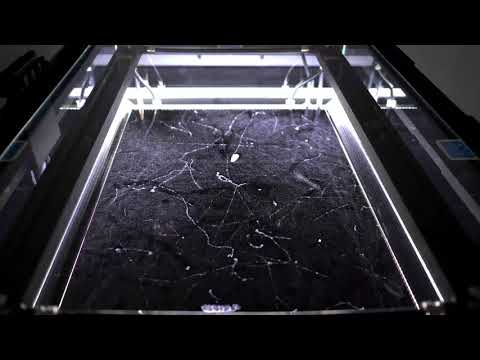

In [ ]:
# @title
YouTubeVideo(width = 560, height = 315, id="i15ef618DP0")

This video is a recording of one of the first types of tracking detectors called a **cloud chamber**. Each of those puffs of smoke is a track left by a charged particle passing through the detector. This type of detector was the inspiration for the background of the [PID Playground homepage](https://duberii.github.io/pid-playground)!


---
##**Drift Chambers**
---
Drift Chambers (as well as cloud chambers and silicon trackers) at their core are just boxes of gas with a grid of wires in them. These wires are extremely close to each other, often to the point where it looks like they touch (even though they do not). The GlueX detector uses a slightly modified detector called a **Straw Chamber**, which has a slightly different layout, with positively charged wires inside negatively charged tubes.

<img width="512" alt="An image of a small piece of a drift chamber" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Chambre-a-derive-IMG_0524.jpg/512px-Chambre-a-derive-IMG_0524.jpg"><br>
<a href="https://commons.wikimedia.org/wiki/File:Chambre-a-derive-IMG_0524.jpg">Rama</a>, <a href="https://creativecommons.org/licenses/by-sa/2.0/fr/deed.en">CC BY-SA 2.0 FR</a>, via Wikimedia Commons

The image show above is a cross section of a drift chamber. You may notice that it seems like the wires in the drift chamber touch, but they actually don't! The reason that these wires are so close together is to ensure that our measurements of the position of the track are as precise as possible.

As a charged particle passes through the gas of the dirft chamber, it knocks electrons off the atoms in the gas. The wires in a drift chamber are positively charged, so these electrons are attracted to the nearest wire. Once the electrons reach the wire, they will produce a small pulse of current in the wire, which can be detected. Each of these pulses of current are called a **hit**, and we can use the path traced out by these hits to determine the shape of the track.

---

####**Question #1:**
---
Which of the following particles would leave a track in a drift chamber?


*   Photon
*   Muon
*   Neutron
*   Neutrino
*   Gluon
*   Positive pion
*   Neutral Kaon
*   W boson


Double click to edit this cell and answer the following question: Which of the following particles would leave a track in a drift chamber?

#####**Solution:**

Any charged particle would leave a track in a cloud chamber. There particles include:
*   Muons
*   Positive pions
*   W bosons

The remaining particles are neutral, and would not leave a track in the drift chamber.

####**Question #2:**
---
In most particle detectors, particles must pass through a drift chamber (or another tracking detector) to reach other detectors. If we detect a particle in one of the other detectors, but don't see any track in the drift chamber, what could we say about the charge of the particle we detected?

Double click to edit this cell and answer the following question: If we detect a particle in one of the other detectors, but don't see any track in the drift chamber, what could we say about the charge of the particle we detected?

#####**Solution:**

The particle we detected must have passed through a drift chamber. If it were charged, it would have left a track in the dirft chamber, which we would have been able to detect. Because we didn't see any tracks, the particle must have been neutral.

---
### **Detecting Tracks**
---

We can determine the position of a track based on the location of the wire it left a signal in. For example, in the GlueX detector, the wires are arranged in rings around the center of the detector. Based on which ring we see a signal in, we can determine the radial coordinate of the hit. A **hit** is an interaction between a particle and the drift chamber, which is detected as a pulse of electricity in one wire (or possibly several wires) in the drift chamber. Based on which wire in that ring has the biggest current pulse, we can determine the angular coordinate of the hit. If you are not familiar with polar coordinates, it will be useful to read about them here: [Click here to read about polar coordinates](https://mathinsight.org/polar_coordinates).

The interactive figure below can be adjusted to plot up to three layers of the wires in GlueX's central drift chamber. Setting a slider to 0 hides that ring, which allows you to plot fewer than three rings at a time. Be sure to run the cell after you change the sliders.

In [ ]:
Ring_1 = 4 # @param {type:"slider", min:0, max:28, step:1}
Ring_2 = 5 # @param {type:"slider", min:0, max:28, step:1}
Ring_3 = 6 # @param {type:"slider", min:0, max:28, step:1}
xs = []
ys = []
zs = []
ring_wires = []
rings = []
for i in wire_positions_df.iloc:
  if i['ring'] in [Ring_1,Ring_2,Ring_3]:
    xs.append(i['pos'][0][0]);
    xs.append(i['pos'][1][0]);
    ys.append(i['pos'][0][1]);
    ys.append(i['pos'][1][1]);
    zs.append(i['pos'][0][2]);
    zs.append(i['pos'][1][2]);
    ring_wires.append("Ring: "+ str(i['ring']) + " Wire: " + str(i['straw']))
    ring_wires.append("Ring: "+ str(i['ring']) + " Wire: " + str(i['straw']))
    rings.append(i['ring'])
    rings.append(i['ring'])
data_to_plot = pd.DataFrame()
data_to_plot['x'] = xs
data_to_plot['y'] = ys
data_to_plot['z'] = zs
data_to_plot['Ring and Wire']=ring_wires
data_to_plot['ring']=rings
fig = px.line_3d(data_frame=data_to_plot,x='x',y='z',z='y',line_group='Ring and Wire',color='ring')
fig.update_traces(line=dict(width=5))
fig.update_layout(title="Rings of the GlueX Central Drift Chamber",legend_title="Ring Number",scene={'aspectmode':'cube','xaxis':{'range':[-60,60],"title":"X"},'yaxis':{'range':[0,175],"title":"Z"},'zaxis':{'range':[-60,60],'title':'Y'}})
fig.show()


Based on the position of the wire we detect a signal in, we can determine the x and y corrdinates of the hit. In later sections, we will see how we can use the layout of the detector to estimate the z coordinate of the hit as well.

Once we have coordinates for all of the hits that are left by a track, we can use the path of the particle to gain information about its momentum.

---

####**Question #3:**
---
Based on the interactive plot shown above, how many "rings" are there in the GlueX central drift chamber (CDC)?

Double click to edit this cell and answer the following question: How many rings are there in the GlueX central drift chamber?

#####**Solution:**

There are a total of 28 layers in the GlueX central drift chamber.

####**Question #4:**
---
Using the interactive plot shown above, plot rings 4, 5, and 9. What differences do you notice between these three rings? **Note:** It may be easier to see the differences if you plot these rings one at a time.

Double click to edit this cell and answer the following question: What differences do you notice between these three rings?

#####**Solution:**

One observation is that as you increase the ring number, the radius of the ring increases. This is due to the fact that the rings are numbered from the smallest radius to the largest radius.

Another observation is that ring 4 has wires that run parallel to the z axis, while rings 5 and 9 have wires that are slightly tilted. Ring 5 and ring 9 (and around 16 other rings in the detector) have wires that are tilted by 6 degrees. These layers are called **stereo layers**, and they actually allow us to more accurately find the z coordinate of a hit based on the timing of the pulse of electricity. Ring 4 is what we call an **axial layer**, meaning its wires are lined up straight in the z direction.

####**Question #5:**
---
The cell below creates a plot of the $x$ and $y$ coordinates of the wires of the drift chamber. There is a z slider, which allows you to change the point along the detector you are looking at. What do you notice about the wire positions as you change the z coordinate? Compare the behavior of ring 4, ring 5, and ring 9.

In [18]:
Ring_1 = 5 # @param {type:"slider", min:0, max:28, step:1}
Ring_2 = 9 # @param {type:"slider", min:0, max:28, step:1}
Ring_3 = 4 # @param {type:"slider", min:0, max:28, step:1}
rings = [Ring_1,Ring_2,Ring_3]
import warnings
warnings.filterwarnings("ignore")
included = [[row['ring']==rings[j] for row in wire_positions_df.iloc] for j in range(3)]
x0 = [np.array([row['pos'][0][0] for row in wire_positions_df.loc[included[j]].iloc]) for j in range(3)]
y0 = [np.array([row['pos'][0][1] for row in wire_positions_df.loc[included[j]].iloc]) for j in range(3)]
x1 = [np.array([row['pos'][1][0] for row in wire_positions_df.loc[included[j]].iloc]) for j in range(3)]
y1 = [np.array([row['pos'][1][1] for row in wire_positions_df.loc[included[j]].iloc]) for j in range(3)]

temp_df = pd.DataFrame()
fig = go.FigureWidget()
for j in range(3):
  fig.add_scatter(x=x0[j],y=y0[j],mode='markers',name="Ring " + str(rings[j]),marker={"size":3})
fig.update_layout(xaxis_range=[-60,60], yaxis_range=[-60,60],width=520,height=500)
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-10.5, y0=-10.5, x1=10.5, y1=10.5,
    line_color="black")
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-55, y0=-55, x1=55, y1=55,
    line_color="black")
fig.update()
def update(z=1):
  global fig
  s= z/175
  with fig.batch_update():
    for j in range(3):
      fig.data[j]['x']=s*x1[j]+(1-s)*x0[j]
      fig.data[j]['y']=s*y1[j]+(1-s)*y0[j]
    fig.update_layout(width=520,height=500)
  fig.show()
interact(update, z=(0,175,0.1))
print("")

interactive(children=(FloatSlider(value=1.0, description='z', max=175.0), Output()), _dom_classes=('widget-int…

Double click to edit this cell and answer the following question: What do you notice about the wire positions as you change the the z coordinate?

#####**Solution:**

As you change the z coordinate, the positions of the stereo rings (the rings whose wires are not straight ) change. Ring 5 is a stereo ring, so as we increase the z coordinate, the tilt of the wire affects its corrdinates more and more, which we interpret as a "moving" of the wire positions. Ring 9 is also a stereo ring, though it is tilted in the other direction, so as we increase the slider, the wires seem to move in the opposite direction of the ring 5 wires. Wire 4, however, is an **axial layer**, so the x and y coordinates of the wire does not change as we change the z coordinate.

---
###**Curvature of Tracks**
---

So far, we haven't talked about how we can actually use these tracks to find the momentum of the particles that leave them. On its own, information about the track doesn't give us the ability to determine the momentum of the particle. Instead, we use a magnetic field to make the path of the particle of the particle curve. Based on the curvature of the track, we are able to infer the momentum of the particle.

This method relies on the fact that charged particles moving in a magnetic field will travel in a circle.


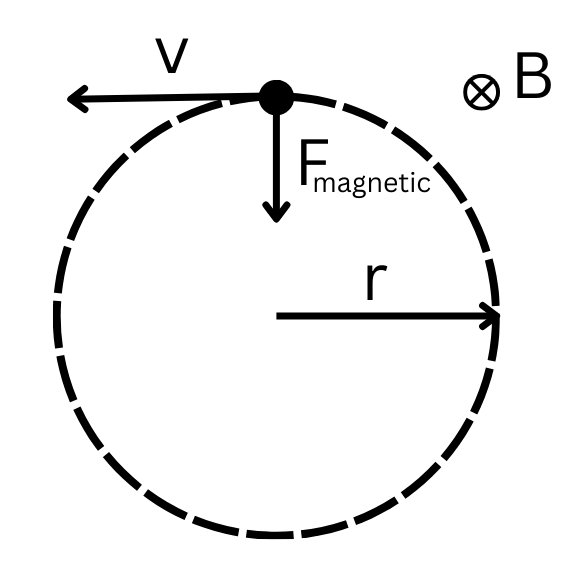

In the image shown above, there is a particle (at the top of the circle), moving with velocity $v$ through a magnetic field with strength $B$. The $\otimes$ symbol tells us that the magnetic field is pointing into the screen. The particle travels in the path given by the dotted line, which is a circle of radius $r$. At every point of the circle, the magnetic force, labelled $F_{magnetic}$ is pointed towards the center of the circle, as is shown above.

We can express the radius of the path as follows:

$$
r_{path} = \frac{|p_\perp|}{|q|B}
$$
where $r_{path}$ is the radius of the path, $|q|$ is the absolute value of the charge of the particle, and $B$ is the stregth of the magnetic field. $p_\perp$ refers to the magnitude of the momentum components that are perpendicular to the direction of the magnetic field. In the GlueX detector, the magnetic field points along the z axis, meaning:
$$
|p_\perp| = \sqrt{p_x^2+p_y^2}
$$
where $p_x$ is the x component of the momentum vector and $p_y$ is the y component of the momentum vector.

Since we know that the particle starts in the center of the detector, the path a particle takes can be entirely expressed in terms of $p_x$ and $p_y$.

Run the cell below to create a plot below of a cross section of the GlueX detector (as if you were looking in the z direction). The black circles represent the boundaries of the central drift chamber. You can modify the sliders to change the values of $p_x$ and $p_y$ to modify the track of the particle, shown in blue. You can also change the slider labelled t_max, which will change how long the track is. t_max is not a property of the track- it is only used for the visualization.

In [27]:
# @title
fig = go.FigureWidget()
fig.update_layout(xaxis_range=[-60,60], yaxis_range=[-60,60],width=500,height=500,showlegend=False,title="Track in the GlueX Detector",xaxis_title="X", yaxis_title="Y")
fig.add_scatter()
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-10.5, y0=-10.5, x1=10.5, y1=10.5,
    line_color="black")
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-55, y0=-55, x1=55, y1=55,
    line_color="black")
fig.update()
def update(charge=1,px=0.2,py=0.2,t_max = np.pi):
  global fig
  center_x = -1*charge*330*py/B
  center_y = charge*330*px/B
  t_curve = np.linspace(0,t_max,1000)
  r_curvature = (center_x**2 + center_y**2)**0.5
  theta_curvature = np.arctan2(-1*center_y,-1*center_x)
  x_track = x_coord(r_curvature,theta_curvature,center_x,t_curve, charge)
  y_track = y_coord(r_curvature,theta_curvature,center_y,t_curve,charge)
  with fig.batch_update():
    fig.data[0]['x']=x_track
    fig.data[0]['y']=y_track
    fig.update_layout(width=500,height=500)
  fig.show()
interact(update, px=(-1,1,0.0001),py=(-1,1,0.0001),t_max=(0,2*np.pi,0.0001),charge = (-1,1,2))
print("")

interactive(children=(IntSlider(value=1, description='charge', max=1, min=-1, step=2), FloatSlider(value=0.2, …

#### **Question #6a:**
---
Change the charge of the simulated particle in the plot above. What about the path of the particle changes when you change the charge?

Double click to edit this cell and answer the following question: What about the path of the particle changes when you change the charge?

#####**Solution:**

Positively charged particles curve counterclockwise, while negatively charged particles curve clockwise. This is reflected in the equation for the magnetic force:
$$
F_{magnetic} = q*v\times B
$$
where $q$ is the charge, $v$ is the velocity vector, $B$ is the magnetic field vector, and $F_{magnetic}$ is the force vector. Particles with opposite charges experience forces in opposite directions, which cause them to curve in opposite directions. Note that $\times$ denotes the cross product, which is an operation between two vectors, not multiplication (which is an operation between two numbers).

#### **Question #6b:**
---
Based on your answer to the previous question, how can we determine the charge of a particle based on its track?

Double click to edit this cell and answer the following question: How can we determine the charge of a particle based on its track?

#####**Solution:**

We can determine the charge of a particle based on the direction it curves. If the particle's track curves counterclockwise, we know the particle must be positively charged. If it curves clockwise, we know the particle must be negatively charged. A neutral particle's track would not curve at all, but neutral particles do not leave tracks.

---
##**Track Fitting**
---

Track fitting is the process of figuring out the momentum vector of the particle pased on individual signals in the detector. There are several values that we need to find to adjust to get a good measurement of the momentum. In this section, we will explore how we can obtain 2 components ($p_x$ and $p_y$) of the momentum vector. While it is possible to obtain the z component of the momentum vector as well, that process is far more tedious. Because track fitting is automated, it is likely not worth your time to spend time figuring out how to find $p_z$, the z component of the momentum vector.

---
###**Step 1: Estimating Z Coordinate**
---

We can find the x coordinate and the y coordinate of a hit based on the ring number and the wire number, but we need to find the z coordinate. The x and y coordinate of the hit also depend on the z coordinate (see question #4).

Below, we plotted the x and y coordinates of several hits left by a track in the GlueX CDC. However, you'll notice that the hits don't seem to line up to produce a smooth track. However, when you adjust the z coordinate using the slider, you'll notice that you can update our estimate of the x and y coordinate of the hits in stereo rings (tilted rings). To find the best estimate of the z coordinate of the hits, we can adjust the slider until the points line up to form a smooth path.

In [11]:
# @title
import warnings
warnings.filterwarnings("ignore")
i = 4
row = track_fitting_events.iloc[i]
x = row['r']*np.cos(row['theta'])
y = row['r']*np.sin(row['theta'])
temp_df = pd.DataFrame()
temp_df['x']=row['r']*np.cos(row['theta'])
temp_df['y']=row['r']*np.sin(row['theta'])
temp_df['ring'] = row['ring']
temp_df['wire'] = row['straw']
fig = go.FigureWidget(px.scatter(data_frame=temp_df,x='x',y='y',hover_data=['ring','wire']))
fig.update_traces(marker={"size":3})
fig.update_layout(xaxis_range=[-60,60], yaxis_range=[-60,60],width=520,height=500,showlegend=False)
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-10.5, y0=-10.5, x1=10.5, y1=10.5,
    line_color="black")
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-55, y0=-55, x1=55, y1=55,
    line_color="black")
fig.update()
def update(z=0):
  global fig
  global temp_df
  new_x = temp_df['x'].to_numpy()
  new_y = temp_df['y'].to_numpy()
  for i in range(len(temp_df['ring'])):
    hit = temp_df.iloc[i]
    if hit['ring'] in [5,6,7,8,9,10,11,12,17,18,19,20,21,22,23,24]:
      strawPos = positionsMatrix[int(hit['ring']-1)][int(hit['wire']-1)]
      s = z/175
      new_x[i]= strawPos[0][0]*s + (1-s)*strawPos[1][0]
      new_y[i]= strawPos[0][1]*s + (1-s)*strawPos[1][1]
  with fig.batch_update():
    fig.update_layout(width=520,height=500)
    fig.data[0]['x']=new_x
    fig.data[0]['y']=new_y
  fig.show()
interact(update, px=(-1,1,0.0001),py=(-1,1,0.0001),pz=(-1,1,0.0001),t_max=(0,2*np.pi,0.0001),charge = (-1,1,2),z=(0,150,0.1))
print("")

interactive(children=(FloatSlider(value=0.0, description='z', max=150.0), Output()), _dom_classes=('widget-int…

For example, the z coordinates for the hits shown above are around 80. Note that these z coordinates are just estimates, so any z coordinate between 75 and 85 should allow you to get a good estimate of the momentum.

#### **Question #7:**
---
Every time you run the following cell, it will plot a new collection of hits with different z coordinates. Run the cell below and use the slider to find a good estimate of the z coordinate of the hits. Feel free to run this cell as many times as you need to practice finding the z values of hits in the CDC.

In [50]:
# @title
import warnings
warnings.filterwarnings("ignore")
i = np.random.randint(0,len(track_fitting_events['ring']))
row = track_fitting_events.iloc[i]
x = row['r']*np.cos(row['theta'])
y = row['r']*np.sin(row['theta'])
temp_df = pd.DataFrame()
temp_df['x']=row['r']*np.cos(row['theta'])
temp_df['y']=row['r']*np.sin(row['theta'])
temp_df['ring'] = row['ring']
temp_df['wire'] = row['straw']
fig = go.FigureWidget(px.scatter(data_frame=temp_df,x='x',y='y',hover_data=['ring','wire']))
fig.update_traces(marker={"size":3})
fig.update_layout(xaxis_range=[-60,60], yaxis_range=[-60,60],width=520,height=500,showlegend=False)
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-10.5, y0=-10.5, x1=10.5, y1=10.5,
    line_color="black")
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-55, y0=-55, x1=55, y1=55,
    line_color="black")
fig.update()
def update(z=0):
  global fig
  global temp_df
  new_x = temp_df['x'].to_numpy()
  new_y = temp_df['y'].to_numpy()
  for i in range(len(temp_df['ring'])):
    hit = temp_df.iloc[i]
    if hit['ring'] in [5,6,7,8,9,10,11,12,17,18,19,20,21,22,23,24]:
      strawPos = positionsMatrix[int(hit['ring']-1)][int(hit['wire']-1)]
      s = z/175
      new_x[i]= strawPos[0][0]*s + (1-s)*strawPos[1][0]
      new_y[i]= strawPos[0][1]*s + (1-s)*strawPos[1][1]
  with fig.batch_update():
    fig.update_layout(width=520,height=500)
    fig.data[0]['x']=new_x
    fig.data[0]['y']=new_y
  fig.show()
interact(update, px=(-1,1,0.0001),py=(-1,1,0.0001),pz=(-1,1,0.0001),t_max=(0,2*np.pi,0.0001),charge = (-1,1,2),z=(0,150,0.1))
print("")

interactive(children=(FloatSlider(value=0.0, description='z', max=150.0), Output()), _dom_classes=('widget-int…

#####**Solution:**

Run the cell below to calculate the z coordinate for the hits shown above. Note that your value may be more accurate than the value produced by the following cell if there are multiple tracks (you can tell if there are multiple track if there are two different paths traced out by the hits). Things like this are easier for you to see than a computer to see!

In [51]:
# @title
def updated_coordinates(z):
  global temp_df
  global positionsMatrix
  new_x = temp_df['x'].to_numpy()
  new_y = temp_df['y'].to_numpy()
  for i in range(len(temp_df['ring'])):
    hit = temp_df.iloc[i]
    if hit['ring'] in [5,6,7,8,9,10,11,12,17,18,19,20,21,22,23,24]:
      strawPos = positionsMatrix[int(hit['ring']-1)][int(hit['wire']-1)]
      s = z/175
      new_x[i]= strawPos[0][0]*s + (1-s)*strawPos[1][0]
      new_y[i]= strawPos[0][1]*s + (1-s)*strawPos[1][1]
  return new_x, new_y

def parametric_curve(t):
  global row
  global B
  center_x = -1*330*row['py']/B
  center_y = 330*row['px']/B
  r_curvature = (center_x**2 + center_y**2)**0.5
  theta_curvature = np.arctan2(-1*center_y,-1*center_x)
  x_track = x_coord(r_curvature,theta_curvature,center_x,t, 1)
  y_track = y_coord(r_curvature,theta_curvature,center_y,t,1)
  return x_track, y_track
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def distance_to_curve(x,y):
  curve = parametric_curve(np.linspace(0,6.28,100))
  distance_to_nearest_curve_point = min([((x-curve[0][j])**2 + (y-curve[1][j])**2)**0.5 for j in range(100)])
  return distance_to_nearest_curve_point

def calculate_rmse(x_points, y_points):
    mse = sum([distance_to_curve(x_points[j],y_points[j])**2 for j in range(len(x_points))])/len(x_points)
    rmse = mse/len(x_points)
    return rmse
rmses = {}
for z in np.linspace(0,150,151):
  new_x, new_y = updated_coordinates(z)
  rmses[z] = calculate_rmse(new_x,new_y)
print("True z value is about " + str(min(rmses, key=rmses.get)))

True z value is about 48.0


---
###**Step 2: Finding Track Momentum and Charge**
---

After our hits are lined up, we can fit the hits to a curve, which we calculate based on $p_x$ and $p_y$. Also, based on the direction of the curvature, we can find the charge of the particle as well.

The cell below creates an interactive plot with sliders for every property of the track. First, use the slider below to adjust the z value until the track hits are lined up. Then, based on the direction the track curves, determine the charge of the particle. Finally, use the sliders to adjust $p_x$ and $p_y$ until the fitted track (the red line) passes through as many hit points as possible. Remember that you can use the t_max slider to increase or decrease the length of the track if necessary.

In [88]:
# @title
import warnings
warnings.filterwarnings("ignore")
i = 10432
row = track_fitting_events.iloc[i]
x = row['r']*np.cos(row['theta'])
y = row['r']*np.sin(row['theta'])
temp_df = pd.DataFrame()
temp_df['x']=row['r']*np.cos(row['theta'])
temp_df['y']=row['r']*np.sin(row['theta'])
temp_df['ring'] = row['ring']
temp_df['wire'] = row['straw']
fig = go.FigureWidget(px.scatter(data_frame=temp_df,x='x',y='y',hover_data=['ring','wire']))
fig.update_traces(marker={"size":3})
fig.update_layout(xaxis_range=[-60,60], yaxis_range=[-60,60],width=510,height=500,showlegend=False)
fig.add_scatter()
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-16, y0=-16, x1=16, y1=16,
    line_color="black")
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-58, y0=-58, x1=58, y1=58,
    line_color="black")
fig.update()
def update(charge=1,px=0,py=0,t_max = np.pi,z=75):
  global fig
  global temp_df
  m=0.000511
  new_x = temp_df['x'].to_numpy()
  new_y = temp_df['y'].to_numpy()
  for i in range(len(temp_df['ring'])):
    hit = temp_df.iloc[i]
    if hit['ring'] in [5,6,7,8,9,10,11,12,17,18,19,20,21,22,23,24]:
      strawPos = positionsMatrix[int(hit['ring']-1)][int(hit['wire']-1)]
      s = z/175
      new_x[i]= strawPos[0][0]*s + (1-s)*strawPos[1][0]
      new_y[i]= strawPos[0][1]*s + (1-s)*strawPos[1][1]
  center_x = -1*charge*330*py/B
  center_y = charge*330*px/B
  t_curve = np.linspace(0,t_max,1000)
  r_curvature = (center_x**2 + center_y**2)**0.5
  theta_curvature = np.arctan2(-1*center_y,-1*center_x)
  x_track = x_coord(r_curvature,theta_curvature,center_x,t_curve, charge)
  y_track = y_coord(r_curvature,theta_curvature,center_y,t_curve,charge)
  with fig.batch_update():
    fig.data[1]['x']=x_track
    fig.data[1]['y']=y_track
    fig.update_layout(width=510,height=500,showlegend=False)
    fig.data[0]['x']=new_x
    fig.data[0]['y']=new_y
  fig.show()
interact(update, px=(-1,1,0.0001),py=(-1,1,0.0001),t_max=(0,2*np.pi,0.0001),charge = (-1,1,2),z=(0,150,0.1))
print("")

interactive(children=(IntSlider(value=1, description='charge', max=1, min=-1, step=2), FloatSlider(value=0.0, …

In this case, we find that the z coordinate of the hits is $z=37$, the x component of the momentum is $p_x=0.08$, the y component of the momentum is $p_y=0.09$, and the charge is +1. Note that we needed to turn t_max all the way up to see the full track. With this, congratulations! You have just fit your first track in GlueX's CDC!

#### **Question #8:**
---
Every time you run the following cell, it will plot a new collection of hits with different z coordinates for track with random momenta. Run the cell below and use the slider to find a good estimate of the z coordinate of the hits, the x component of momentum, the y component of the momentum, and the charge. Feel free to run this cell as many times as you need to practice fitting tracks in the CDC.

In [ ]:
# @title
import warnings
warnings.filterwarnings("ignore")
i = np.random.randint(0,len(track_fitting_events['ring']))
row = track_fitting_events.iloc[i]
x = row['r']*np.cos(row['theta'])
y = row['r']*np.sin(row['theta'])
temp_df = pd.DataFrame()
temp_df['x']=row['r']*np.cos(row['theta'])
temp_df['y']=row['r']*np.sin(row['theta'])
temp_df['ring'] = row['ring']
temp_df['wire'] = row['straw']
fig = go.FigureWidget(px.scatter(data_frame=temp_df,x='x',y='y',hover_data=['ring','wire']))
fig.update_layout(xaxis_range=[-60,60], yaxis_range=[-60,60],width=510,height=500,showlegend=False)
fig.add_scatter()
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-16, y0=-16, x1=16, y1=16,
    line_color="black")
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=-58, y0=-58, x1=58, y1=58,
    line_color="black")
fig.update()
def update(charge=1,px=0,py=0,t_max = np.pi,z=75):
  global fig
  global temp_df
  m=0.000511
  new_x = temp_df['x'].to_numpy()
  new_y = temp_df['y'].to_numpy()
  for i in range(len(temp_df['ring'])):
    hit = temp_df.iloc[i]
    if hit['ring'] in [5,6,7,8,9,10,11,12,17,18,19,20,21,22,23,24]:
      strawPos = positionsMatrix[int(hit['ring']-1)][int(hit['wire']-1)]
      s = z/175
      new_x[i]= strawPos[0][0]*s + (1-s)*strawPos[1][0]
      new_y[i]= strawPos[0][1]*s + (1-s)*strawPos[1][1]
  center_x = -1*charge*330*py/B
  center_y = charge*330*px/B
  t_curve = np.linspace(0,t_max,1000)
  r_curvature = (center_x**2 + center_y**2)**0.5
  theta_curvature = np.arctan2(-1*center_y,-1*center_x)
  x_track = x_coord(r_curvature,theta_curvature,center_x,t_curve, charge)
  y_track = y_coord(r_curvature,theta_curvature,center_y,t_curve,charge)
  with fig.batch_update():
    fig.data[1]['x']=x_track
    fig.data[1]['y']=y_track
    fig.update_layout(width=510,height=500,showlegend=False)
    fig.data[0]['x']=new_x
    fig.data[0]['y']=new_y
  fig.show()
interact(update, px=(-1,1,0.0001),py=(-1,1,0.0001),t_max=(0,2*np.pi,0.0001),charge = (-1,1,2),z=(0,150,0.1))
print("")

#####**Solution:**

Run the cell below to see the true z coordinate, momentum, and charge of the particle that left the hits shown above. Note that your values may be more accurate than the value produced by the following cell if there are multiple tracks (you can tell if there are multiple track if there are two different paths traced out by the hits). Things like this are easier for you to see than a computer to see!

In [85]:
# @title
def updated_coordinates(z):
  global temp_df
  global positionsMatrix
  new_x = temp_df['x'].to_numpy()
  new_y = temp_df['y'].to_numpy()
  for i in range(len(temp_df['ring'])):
    hit = temp_df.iloc[i]
    if hit['ring'] in [5,6,7,8,9,10,11,12,17,18,19,20,21,22,23,24]:
      strawPos = positionsMatrix[int(hit['ring']-1)][int(hit['wire']-1)]
      s = z/175
      new_x[i]= strawPos[0][0]*s + (1-s)*strawPos[1][0]
      new_y[i]= strawPos[0][1]*s + (1-s)*strawPos[1][1]
  return new_x, new_y

def parametric_curve(t):
  global row
  global B
  center_x = -1*330*row['py']/B
  center_y = 330*row['px']/B
  r_curvature = (center_x**2 + center_y**2)**0.5
  theta_curvature = np.arctan2(-1*center_y,-1*center_x)
  x_track = x_coord(r_curvature,theta_curvature,center_x,t, 1)
  y_track = y_coord(r_curvature,theta_curvature,center_y,t,1)
  return x_track, y_track
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def distance_to_curve(x,y):
  curve = parametric_curve(np.linspace(0,6.28,100))
  distance_to_nearest_curve_point = min([((x-curve[0][j])**2 + (y-curve[1][j])**2)**0.5 for j in range(100)])
  return distance_to_nearest_curve_point

def calculate_rmse(x_points, y_points):
    mse = sum([distance_to_curve(x_points[j],y_points[j])**2 for j in range(len(x_points))])/len(x_points)
    rmse = mse/len(x_points)
    return rmse
rmses = {}
for z in np.linspace(0,150,151):
  new_x, new_y = updated_coordinates(z)
  rmses[z] = calculate_rmse(new_x,new_y)
print('The true px value is: ' + str(row['px']) + " GeV/c")
print('The true py value is: ' + str(row['py']) + " GeV/c")
print("The true z value is about " + str(min(rmses, key=rmses.get)))
print("The charge of the particle is 1")

The true px value is: 0.07811249047517776 GeV/c
The true py value is: 0.08721448481082916 GeV/c
The true z value is about 37.0
The charge of the particle is -1
